In [90]:
import numpy as np
import ltspice
import matplotlib.pyplot as plt
import pandas as pd
import re

# Simulation results v1

## Store simulation?

In [91]:
store_sim = False
DC_analysis = False
R_analysis = True

## Active resistance

[Warning] Variable data type is detected as double precision.


ValueError: x, y, and format string must not be None

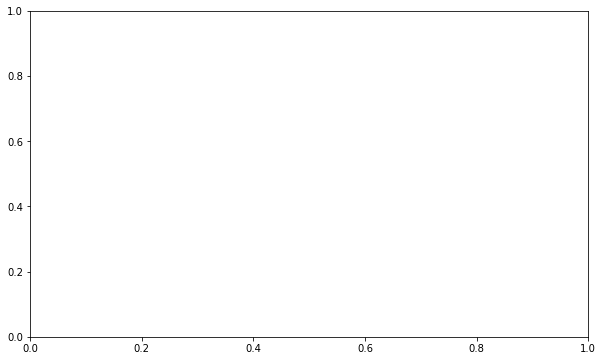

In [92]:
if R_analysis==True:    
    filepath = '../../netlist/tb_inv_sky130_a_noise_res_DC_v2.raw'  # Update to your file's path

    # Load the LTSpice file
    lt = ltspice.Ltspice(filepath)
    lt.parse()

    # Get the data
    time = lt.get_time()
    r = lt.get_data('r')
    vin = lt.get_data('vin')

    plt.figure(figsize=(10, 6))
    plt.plot(vin, r, label='R vs Vin')
    plt.title('DC resistance')
    plt.xlabel('Vin (V)')
    plt.ylabel('R (V)')
    plt.grid(True)
    plt.legend()
    plt.show()


## Loading values of parameters

In [ ]:
# Arrays to store the results of the simulations
param_values = np.zeros(19)    # order: Vdd, Wn, Ln, Wp, Lp, Wr1, Lr1, R_1, Wr2, Lr2, R_2, Wc1, Lc1, MFc1, C_1, Wc2, Lc2, Mfc2, C_2 Vdc
results_sim = np.zeros(4)    # order: gain (in dB), cut-off, noise, power

def extract_spice_params(file_path):
    # Parameters to extract
    params = {
        'Vdd': None,
        'Wn': None,
        'Ln': None,
        'Wp': None,
        'Lp': None,
        'Wr1': None,
        'Lr1': None,
        'R_1': None,
        'Wr2': None,
        'Lr2': None,
        'R_2': None,
        'Wc1': None,
        'Lc1': None,
        'MFc1': None,
        'C_1': None,
        'Wc2': None,
        'Lc2': None,
        'MFc2': None,
        'C_2': None,
        'Vdc': None
    }
    
    # Open and read the SPICE file
    with open(file_path, 'r') as file:
        content = file.readlines()
    
    # Regex patterns to capture values
    patterns = {
        'Vdd': r'VP VCC GND (\d+\.?\d*)',
        'Vdc': r'Vin in GND (\d+\.?\d*) ac',
        'Wn': r'x1 test net1 VCC VSS not W_N=(\d+\.?\d*) L_N=',  # Adjusted to target the specific line
        'Ln': r'x1 test net1 VCC VSS not .*L_N=(\d+\.?\d*) W_P=',  # Adjusted to target the specific line
        'Wp': r'x1 test net1 VCC VSS not .*W_P=(\d+\.?\d*)',
        'Lp': r'x1 test net1 VCC VSS not .*L_P=(\d+\.?\d*) m=',  # Adjusted to target the specific line
        'Wr1': r'XR1 .+ W=(\d+\.?\d*) L=',
        'Lr1': r'XR1 .+ L=(\d+\.?\d*) mult=',
        'R_1': r'XR1 .+ mult=(\d+\.?\d*)',
        'Wr2': r'XR2 .+ W=(\d+\.?\d*) L=',
        'Lr2': r'XR2 .+ L=(\d+\.?\d*) mult=',
        'R_2': r'XR2 .+ mult=(\d+\.?\d*)',
        'Wc1': r'XC1 .+ W=(\d+\.?\d*) L=',
        'Lc1': r'XC1 .+ L=(\d+\.?\d*)',
        'MFc1': r'XC1 .+ MF=(\d+\.?\d*) m=',
        'Wc2': r'XC2 .+ W=(\d+\.?\d*) L=',
        'Lc2': r'XC2 .+ L=(\d+\.?\d*)',
        'MFc2': r'XC2 .+ MF=(\d+\.?\d*) m='
    }
    
    # Extract parameters
    for line in content:
        for key, pattern in patterns.items():
            match = re.search(pattern, line)
            if match:
                params[key] = float(match.group(1))

    # Calculate capacitance using the given formula
    if params['Wc1'] and params['Lc1'] and params['MFc1']:
        params['C_1'] = params['MFc1'] * params['Wc1'] * params['Lc1']  # Simple multiplication
    
    # Calculate capacitance using the given formula
    if params['Wc2'] and params['Lc2'] and params['MFc2']:
        params['C_2'] = params['MFc2'] * params['Wc2'] * params['Lc2']  # Simple multiplication

    # Convert to NumPy array
    param_values = np.array([params[key] for key in params], dtype=float)
    
    return param_values

# Usage
file_path = "../../netlist/tb_inv_sky130_a_v2.spice"
param_values = extract_spice_params(file_path)
print("The values of the parameters are: ")
print("Vdd = ", param_values[0])
print("Wn = ", param_values[1])
print("Ln = ", param_values[2])
print("Wp = ", param_values[3])
print("Lp = ", param_values[4])
print("Wr1 = ", param_values[5])
print("Lr1 = ", param_values[6])
param_values[7] = 2e3*param_values[6]/param_values[5]
print("R_1 = ", param_values[7])
print("Wr2 = ", param_values[8])
print("Lr2 = ", param_values[9])
param_values[10] = 2e3*param_values[9]/param_values[8]
print("R_2 = ", param_values[10])
print("Wc1 = ", param_values[11])
print("Lc1 = ", param_values[12])
print("MFc1 = ", param_values[13])
param_values[14] = param_values[13] * (param_values[11] * param_values[12] * 2e-15 + (param_values[11] + param_values[12]) * 0.38e-15)
print("C_1 = ", param_values[14])
print("Wc2 = ", param_values[15])
print("Lc2 = ", param_values[16])
print("MFc2 = ", param_values[17])
param_values[18] = param_values[17] * (param_values[16] * param_values[15] * 2e-15 + (param_values[16] + param_values[15]) * 0.38e-15)
print("C_2 = ", param_values[18])
print("Vdc = ", param_values[19])

R1_value = param_values[7]
R2_value = param_values[10]
C1_value = param_values[14]*1e15   # Convert to fF
C2_value = param_values[18]*1e15    # Convert to fF

The values of the parameters are: 
Vdd =  1.125
Wn =  250.0
Ln =  1.0
Wp =  200.0
Lp =  0.25
Wr1 =  nan
Lr1 =  nan
R_1 =  nan
Wr2 =  nan
Lr2 =  nan
R_2 =  nan
Wc1 =  22.0
Lc1 =  22.0
MFc1 =  1.0
C_1 =  9.8472e-13
Wc2 =  14.0
Lc2 =  15.0
MFc2 =  1.0
C_2 =  4.3102e-13
Vdc =  0.53577


## Loading OP

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_op_v2.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

op = np.zeros(8)    # order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp, C_gdn, C_gdp

# Get the data by specifying the trace name
gmn = lt.get_data('gmn')
gmp = lt.get_data('gmp')
gdsn = lt.get_data('gdsn')
gdsp = lt.get_data('gdsp')
cgsn = lt.get_data('cgsn')
cgsp = lt.get_data('cgsp')
cgdn = lt.get_data('cgdn')
cgdp = lt.get_data('cgdp')

# Create numpy array
#The values are stored in the following order: G_mn, G_mp, G_dsn, G_dsp, C_gsn, C_gsp
op = np.array([gmn, gmp, gdsn, gdsp, abs(cgsn), abs(cgsp), abs(cgdn), abs(cgdp)]).flatten()
print("The operating point values are:")
print("gmn = ", op[0])
print("gmp = ", op[1])
print("gdsn = ", op[2])
print("gdsp = ", op[3])
print("cgsn = ", op[4])
print("cgsp = ", op[5])
print("cgdn = ", op[6])
print("cgdp = ", op[7])

[Warning] Variable data type is detected as double precision.
The operating point values are:
gmn =  1.2675525790862897e-05
gmp =  1.3741996274414854e-05
gdsn =  0.0006537867662963263
gdsp =  2.873795285334869e-07
cgsn =  3.912076689261905e-13
cgsp =  3.593444929561779e-14
cgdn =  7.726932309826353e-13
cgdp =  3.9655027238529126e-19


## Noise

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_noise_v2.raw'  # Update to your file's path

# Load the LTSpice file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the data by specifying the trace name
inoise = lt.get_data('v(inoise_total)')[0]*1e6  # Convert to uV
print("The noise values are:")
print(f"inoise total = {inoise} uV")


[Warning] Variable data type is detected as double precision.
The noise values are:
inoise total = 24707.331958972616 uV


[Warning] Variable data type is detected as double precision.


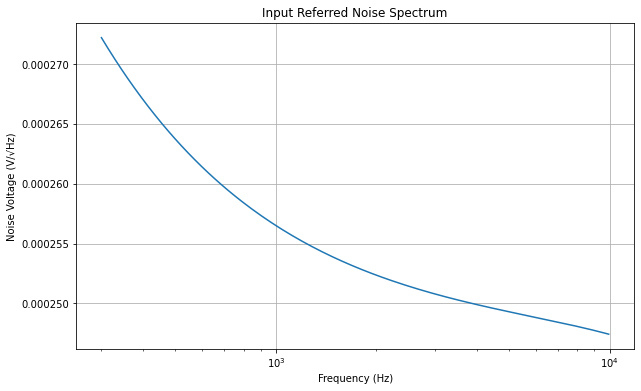

In [ ]:
# Specify the path to your .raw file
filepath = '../../netlist/tb_inv_sky130_a_noise_spectrum_v2.raw'

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Fetch frequency and inoise data
frequency = lt.get_frequency()  # Frequency data
inoise_spectrum = lt.get_data('inoise_spectrum')  # Total input-referred noise

plt.figure(figsize=(10, 6))
plt.semilogx(frequency, inoise_spectrum)
plt.title('Input Referred Noise Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise Voltage (V/√Hz)')
plt.grid(True)
plt.show()

## DC analysis

[Warning] Variable data type is detected as double precision.


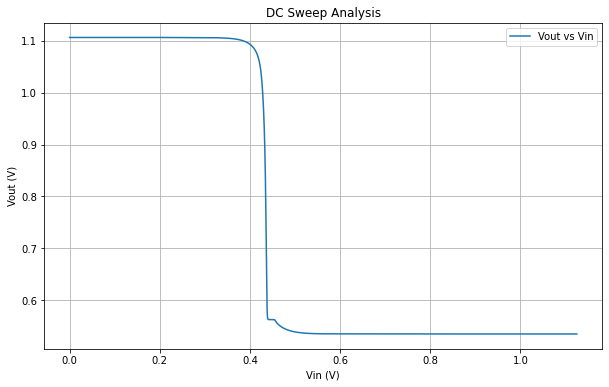

In [ ]:
if DC_analysis == True:
    filepath = '../../netlist/tb_inv_sky130_a_DC_v2.raw'

    # Load the LTSpice raw file
    lt = ltspice.Ltspice(filepath)
    lt.parse()

    # Get the data
    time = lt.get_time()
    vin = lt.get_data('V(in)')
    vout = lt.get_data('V(out)')

    plt.figure(figsize=(10, 6))
    plt.plot(vin, vout, label='Vout vs Vin')
    plt.title('DC Sweep Analysis')
    plt.xlabel('Vin (V)')
    plt.ylabel('Vout (V)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
if DC_analysis == True:
    differences = np.abs(vin - vout)
    op_point = np.argmin(differences)/1e2    # in mV
    print(f"The DC operating point is: {op_point} mV")

The DC operating point is: 535.77 mV


## AC analysis

Maximum Gain: -41.61435004758338 dB
Lower Cutoff Frequency: None Hz
Upper Cutoff Frequency: 1.6218100973589122 Hz


/Users/miguelcorrea/opt/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


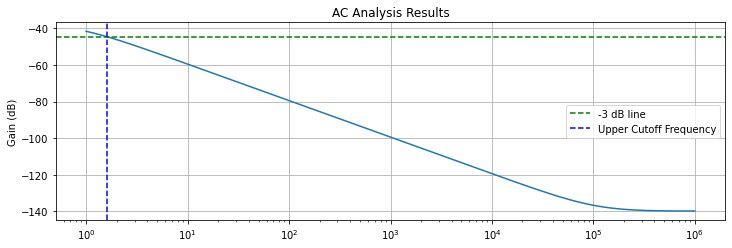

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_AC_v2.raw' 

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get frequency, gain, and phase data
frequency = lt.get_frequency()
gain_sim = lt.get_data('gain')  # Make sure the label matches what's in the .raw file
phase = lt.get_data('phase')  # Make sure the label matches what's in the .raw file

# Calculate the peak gain and determine the -3 dB points from this peak gain
max_gain_sim = np.max(gain_sim)
peak_gain = max_gain_sim  # Ensure this is the peak gain
max_gain_index = np.argmax(gain_sim)

# Determine -3 dB points
db3_drop = peak_gain - 3

# Find the lower cutoff frequency by searching to the left of the peak gain index
lower_cutoff_indices = np.where(gain_sim[:max_gain_index] <= db3_drop)[0]
lower_cutoff_frequency_sim = frequency[lower_cutoff_indices[-1]] if lower_cutoff_indices.size > 0 else None

# For the upper cutoff frequency, find the closest to the simulation result
upper_cutoff_indices = np.where(gain_sim[max_gain_index:] <= db3_drop)[0]
if upper_cutoff_indices.size > 0:
    upper_cutoff_index = upper_cutoff_indices[0] + max_gain_index
    upper_cutoff_frequency_sim = frequency[upper_cutoff_index]
else:
    upper_cutoff_frequency_sim = None
    
print(f"Maximum Gain: {peak_gain.real} dB")
print(f"Lower Cutoff Frequency: {lower_cutoff_frequency_sim} Hz")
print(f"Upper Cutoff Frequency: {upper_cutoff_frequency_sim} Hz")

plt.figure(figsize=(12, 8))

# Plot gain
plt.subplot(2, 1, 1)
plt.semilogx(frequency, gain_sim)
plt.axhline(y=db3_drop, color='green', linestyle='--', label='-3 dB line')
if lower_cutoff_frequency_sim:
    plt.axvline(x=lower_cutoff_frequency_sim, color='red', linestyle='--', label='Lower Cutoff Frequency')
if upper_cutoff_frequency_sim:
    plt.axvline(x=upper_cutoff_frequency_sim, color='blue', linestyle='--', label='Upper Cutoff Frequency')
plt.title('AC Analysis Results')
plt.ylabel('Gain (dB)')
plt.grid(True)
plt.legend()
plt.show()

## Power (and trans) simulation

[Warning] Variable data type is detected as double precision.


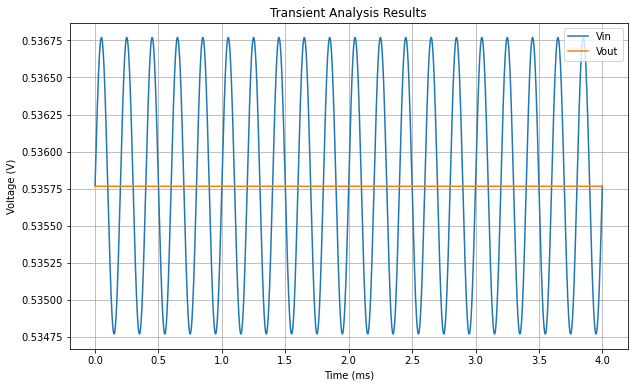

In [ ]:
filepath = '../../netlist/tb_inv_sky130_a_tran_v2.raw'  # Update to your .raw file path

# Load the LTSpice raw file
lt = ltspice.Ltspice(filepath)
lt.parse()

# Get the time and voltage data
time = lt.get_time()
v_in = lt.get_data('V(in)')
v_out = lt.get_data('V(out)')

# Plot the voltages
plt.figure(figsize=(10, 6))
plt.plot(time * 1e3, v_in, label='Vin')
plt.plot(time * 1e3, v_out, label='Vout')
plt.title('Transient Analysis Results')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
avg_pw_total = lt.get_data('avg_pw_total')[0]*1e6  # Convert to uW
print(f"The average power is: {abs(avg_pw_total)} uW")

The average power is: 0.6278714 uW


#### Results of simulation summary

In [ ]:
# Here I will store my real simulation outputs
# order: gain (in dB), cut-off, noise, power
results_sim = np.array([max_gain_sim.real, abs(lower_cutoff_frequency_sim),abs(upper_cutoff_frequency_sim), abs(inoise), abs(avg_pw_total)])
print("The results of the simulation are: ")
print(f"Gain = {results_sim[0]} dB")
print(f"Lower cut-off = {results_sim[1]} Hz")
print(f"Upper cut-off = {results_sim[2]/1e3} kHz")
print(f"Noise = {results_sim[3]} uV")
print(f"Power = {results_sim[4]} uW")

TypeError: bad operand type for abs(): 'NoneType'

## Other simulation results

In [ ]:
if store_sim == True:
    with open('param_values_v2.txt', 'ab') as f:  # 
        np.savetxt(f, param_values, fmt='%e', delimiter=',')
    with open('results_sim_v2.txt', 'ab') as f:  # 
        np.savetxt(f, results_sim, fmt='%e', delimiter=',')

In [ ]:
# Load data from text files
loaded_param_values = np.loadtxt('param_values_v2.txt', delimiter=',')
loaded_results_sim = np.loadtxt('results_sim_v2.txt', delimiter=',')

# Calculate the number of simulations based on the expected structure
num_simulations_params = loaded_param_values.size // 20  # Assuming 20 parameters per simulation
num_simulations_sim = loaded_results_sim.size // 5     # Assuming 5 simulated results per simulation

# Reshape arrays to match the number of simulations and parameters
loaded_param_values = loaded_param_values.reshape(num_simulations_params, 20)
loaded_results_sim = loaded_results_sim.reshape(num_simulations_sim, 5)


# Create DataFrames from the reshaped arrays
# order: Vdd, Wn, Ln, Wp, Lp, Wr1, Lr1, R_1, Wr2, Lr2, R_2, Wc1, Lc1, MFc1, C_1, Wc2, Lc2, MFc2, C_2, Vdc
df_parameters = pd.DataFrame(loaded_param_values, columns=['Vdd', 'Wn', 'Ln', 'Wp', 'Lp', 'Wr1', 'Lr1', 'R1 (in kOhms)',
                                                            'Wr2', 'Lr2', 'R2 (in kOhms)', 'Wc1', 'Lc1', 'MFc1', 'C1 (in pF)',
                                                            'Wc2', 'Lc2', 'MFc2', 'C2 (in pF)', 'Vdc (in mV)'])

df_simulated_results = pd.DataFrame(loaded_results_sim, columns=['gain (in dB)', 'lower cut-off frequency (in Hz)','upper cut-off frequency (in kHz)', 'noise in (uV)', 'power (in uW)'])

df_complete_simulation_results = pd.concat([df_parameters, df_simulated_results], axis=1)

df_complete_simulation_results['R1 (in kOhms)'] = df_complete_simulation_results['R1 (in kOhms)'] / 1000
df_complete_simulation_results['R2 (in kOhms)'] = df_complete_simulation_results['R2 (in kOhms)'] / 1000
df_complete_simulation_results['C1 (in pF)'] = df_complete_simulation_results['C1 (in pF)'] * 1e12
df_complete_simulation_results['C2 (in pF)'] = df_complete_simulation_results['C2 (in pF)'] * 1e12
df_complete_simulation_results['Vdc (in mV)'] = df_complete_simulation_results['Vdc (in mV)'] * 1e3

df_complete_simulation_results.to_csv('complete_simulation_results_v2.csv', index=False)

df_complete_simulation_results

/var/folders/kf/ylc1lssd1yn8zng1yqdkp1300000gn/T/ipykernel_27291/2934563148.py:2: UserWarning: loadtxt: Empty input file: "param_values_v2.txt"
  loaded_param_values = np.loadtxt('param_values_v2.txt', delimiter=',')
/var/folders/kf/ylc1lssd1yn8zng1yqdkp1300000gn/T/ipykernel_27291/2934563148.py:3: UserWarning: loadtxt: Empty input file: "results_sim_v2.txt"
  loaded_results_sim = np.loadtxt('results_sim_v2.txt', delimiter=',')


,Vdd,Wn,Ln,Wp,Lp,Wr1,Lr1,R1 (in kOhms),Wr2,Lr2,...,Wc2,Lc2,MFc2,C2 (in pF),Vdc (in mV),gain (in dB),lower cut-off frequency (in Hz),upper cut-off frequency (in kHz),noise in (uV),power (in uW)
